In [1]:
!pip install .
!pip install pandas scikit-learn tensorboard torch tqdm
!pip install pyinterpx

Processing /data/tedwar42/thelfer1/TorchGRTL
  Preparing metadata (setup.py) ... done
  Created wheel for GeneralRelativity: filename=GeneralRelativity-0.1-py3-none-any.whl size=3660 sha256=5ca4d9b96a90c8d54e3c72ba1c15fff2c4cb5830eb93032a494bb4de6fd24621
  Stored in directory: /tmp/pip-ephem-wheel-cache-msvr6yy8/wheels/67/3f/b7/b7b472c1395273a8376b6665a5562d40b224035f0c4c3d28f9
Successfully built GeneralRelativity
  Attempting uninstall: GeneralRelativity
    Found existing installation: GeneralRelativity 0.1
    Uninstalling GeneralRelativity-0.1:
      Successfully uninstalled GeneralRelativity-0.1

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import r2_score
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

%reload_ext tensorboard
from GeneralRelativity.Utils import (
    get_box_format,
    TensorDict,
    cut_ghosts,
    keys,
    keys_all,
)
from GeneralRelativity.DimensionDefinitions import FOR1, FOR2, FOR3, FOR4
from GeneralRelativity.FourthOrderDerivatives import diff1, diff2
from pyinterpx.Interpolation import *
from GeneralRelativity.TensorAlgebra import (
    compute_christoffel,
    compute_trace,
    compute_christoffel_fast,
    raise_all,
)
from GeneralRelativity.CCZ4Geometry import compute_ricci
from GeneralRelativity.Constraints import constraint_equations

from torch.utils.data import DataLoader, TensorDataset, random_split

time_stamp = int(time.time())

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Executing the model on :", device)

torch.manual_seed(1)
np.random.seed(4)
writer = SummaryWriter()

Executing the model on : cuda:0


In [4]:
small_data = True

# Loading small testdata
if small_data:
    filenamesX = (
        "/home/thelfer1/scr4_tedwar42/thelfer1/data_gen_binary/outputXdata_level1_*"
    )
    num_vars = 100
    factor = 2  # how much refinement
    scaling_factor = 1e-2  # Scaling factor for error
    dataX = get_box_format(filenamesX, num_vars)
    # Cutting out extra values added for validation
    dataX = dataX[:, :, :, :, :25]
else:
    # Instantiate the model
    factor = 2  # how much refinement
    res_level = 6
    scaling_factor = 1e-3
    filenamesX = f"/home/thelfer1/scr4_tedwar42/thelfer1/high_end_data/outputXdata_level{res_level}_step*.dat"

    num_vars = 25
    dataX = get_box_format(filenamesX, num_vars)
    # Cutting out extra values added for validation
    dataX = dataX[:, :, :, :, :25]

dataX_shape = dataX.shape
# Permute data to put the channel as the second dimension (N, C, H, W, D)
dataX = dataX.permute(0, 4, 1, 2, 3)

Loading data


  0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
# A small default model
class SuperResolution3DNet(torch.nn.Module):
    def __init__(self, factor):
        super(SuperResolution3DNet, self).__init__()
        self.points = 6
        self.power = 3
        self.channels = 25
        self.interpolation = interp(
            num_points=self.points,
            max_degree=self.power,
            num_channels=self.channels,
            learnable=False,
            align_corners=True,
            factor=factor,
            dtype=torch.double,
        )

        # Encoder
        # The encoder consists of two 3D convolutional layers.
        # The first conv layer expands the channel size from 25 to 64.
        # The second conv layer further expands the channel size from 64 to 128.
        # ReLU activation functions are used for non-linearity.
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv3d(25, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 25, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
        )

        # Decoder
        # The decoder uses a transposed 3D convolution (or deconvolution) to upsample the feature maps.
        # The channel size is reduced from 128 back to 64.
        # A final 3D convolution reduces the channel size back to the original size of 25.
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(64, 25, kernel_size=3, padding=1),
        )

        # Initialize only the weights in self.encoder and self.decoder
        # self.initialize_encoder_decoder_weights()

    def initialize_encoder_decoder_weights(self):
        for m in [self.encoder, self.decoder]:
            for layer in m:
                if isinstance(layer, torch.nn.Conv3d) or isinstance(
                    layer, torch.nn.ConvTranspose3d
                ):
                    if hasattr(layer, "weight") and layer.weight is not None:
                        init.normal_(
                            layer.weight, mean=0, std=1e-3
                        )  # Adjust std as needed
                        if layer.bias is not None:
                            init.constant_(layer.bias, 0)

    def forward(self, x):
        # Reusing the input data for faster learning

        x = self.interpolation(x)
        tmp = x
        x = x + self.encoder(tmp) * scaling_factor

        return x

In [6]:
# global step counter
counter = 0

losses_train = []
losses_val = []
losses_val_interp = []
steps_val = []

In [7]:
# Create a random 3D low-resolution input tensor (batch size, channels, depth, height, width)
input_tensor = torch.randn(
    1, dataX_shape[4], dataX_shape[1] // 2, dataX_shape[2] // 2, dataX_shape[3] // 2
).to(torch.double)

# Instantiate the model
net = SuperResolution3DNet(factor).to(torch.double)

restart = False
file_path = "Run14315038/model_epoch_counter_0000000240_data_time_1718928325.pth"
if restart and os.path.exists(file_path):
    net.load_state_dict(torch.load(file_path))

# Forward pass to obtain the high-resolution output
output_tensor = net(input_tensor)
# Relevant for ghosts
diff = (dataX_shape[-2] - output_tensor.shape[-1]) // 2
print(diff)
# Check the shape of the output
print("Input Shape:", input_tensor.shape)
print("Output Shape:", output_tensor.shape)

5
Input Shape: torch.Size([1, 25, 8, 8, 8])
Output Shape: torch.Size([1, 25, 6, 6, 6])


In [8]:
optimizerBFGS = torch.optim.LBFGS(
    net.parameters(), lr=0.1
)  # Use LBFGS sometimes, it really does do magic sometimes, though its a bit expensive
optimizerADAM = torch.optim.Adam(net.parameters(), lr=0.0001)

In [9]:
# Define the ratio for the split (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio
batch_size = 100

# Calculate the number of samples for each split
num_samples = len(dataX)
num_train = int(train_ratio * num_samples)
num_test = num_samples - num_train


# Create a dataset from tensors
dataset = TensorDataset(dataX)

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# Create DataLoader for batching -- in case data gets larger
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)  # Batch size for test can be larger if you have the memory

In [10]:
# Magical loss coming from General Relativity
class Hamiltonian_loss:
    def __init__(self, oneoverdx: float):
        self.oneoverdx = oneoverdx

    def __call__(self, output: torch.tensor, dummy: torch.tensor) -> torch.tensor:
        # For learning we need shape (batch,channel,x,y,z), however TorchGRTL works with (batch,x,y,z,channel), thus the permute
        output = output.permute(0, 2, 3, 4, 1)
        # cutting ghosts off, otherwise you will run into problems later
        dataXcut = cut_ghosts(output)

        # creating dict with values
        vars = TensorDict(dataXcut, keys)
        # creating dict with derivatives
        d1 = TensorDict(diff1(output, oneoverdx), keys)
        d2 = TensorDict(diff2(output, oneoverdx**2), keys)
        # calculating variables required for constraints
        h_UU = torch.inverse(vars["h"])
        chris = compute_christoffel(d1["h"], h_UU)
        # Computing Constraints
        out = constraint_equations(vars, d1, d2, h_UU, chris)
        loss = torch.mean(out["Ham"] * out["Ham"])
        return loss


if small_data:
    oneoverdx = (2 * 32.0) / 16.0
else:
    oneoverdx = (64.0 * 2**res_level) / 512.0

print(f"dx = {1./oneoverdx}")
my_loss = Hamiltonian_loss(oneoverdx)

dx = 0.25


training


  0%|          | 0/3 [00:00<?, ?it/s]

0.0007750214646190285
0.000646699765728316
0.0005960364293895041


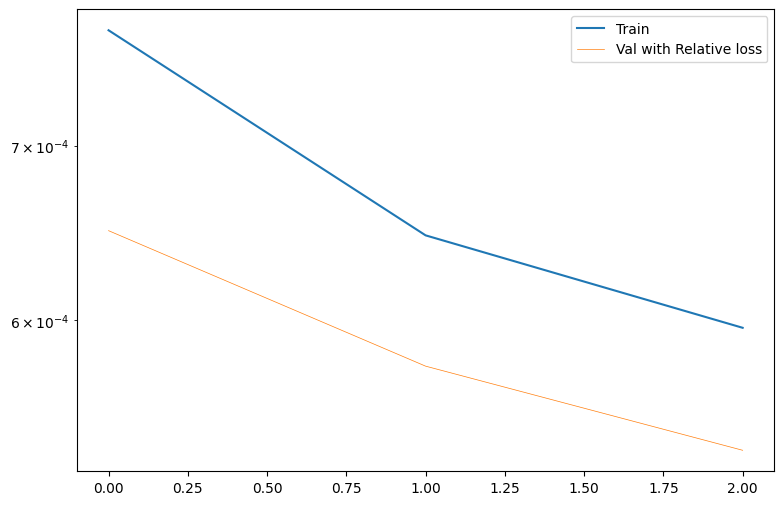

In [11]:
# Note: it will slow down signficantly with BFGS steps, they are 10x slower, just be aware!
ADAMsteps = 3  # Will perform # steps of ADAM steps and then switch over to BFGS-L
n_steps = 3  # Total amount of steps

net.train()
net.to(device)

# my_loss = torch.nn.L1Loss()

print("training")
pbar = trange(n_steps)
for i in pbar:
    total_loss_train = 0
    for (y_batch,) in train_loader:
        batchcounter = 0
        # for X_batch, y_batch in train_loader:
        y_batch = y_batch.to(device)
        X_batch = y_batch[:, :, ::2, ::2, ::2].clone()
        y_batch = y_batch[
            :, :25, diff - 1 : -diff - 1, diff - 1 : -diff - 1, diff - 1 : -diff - 1
        ]
        batchcounter += 1

        # This is needed for LBFGS
        def closure():
            if torch.is_grad_enabled():
                optimizerBFGS.zero_grad()
            y_pred = net(X_batch)

            loss_train = my_loss(y_pred, y_batch)
            if loss_train.requires_grad:
                loss_train.backward()
            return loss_train

        # doing some ADAM first to warm up, sometimes BFGS fuckes up if you start too early
        if counter < ADAMsteps:
            y_pred = net(X_batch)

            loss_train = my_loss(y_pred, y_batch)
            optimizerADAM.zero_grad()
            loss_train.backward()
            optimizerADAM.step()
            # print(f'ADAM {batchcounter}')

        else:
            optimizerBFGS.step(closure)
            # print(f'BFGS {batchcounter}')

        loss_train = closure()
        total_loss_train += loss_train.item()
    # Calculate the average training loss
    average_loss_train = total_loss_train / len(train_loader)
    print(average_loss_train)
    # Log the average training loss
    writer.add_scalar("loss/train", average_loss_train, counter)
    losses_train.append(average_loss_train)
    if np.isnan(average_loss_train):
        print("we got nans")

    # Validation

    if counter % 1 == 0:
        with torch.no_grad():
            total_loss_val = 0.0
            interp_val = 0.0
            for (y_val_batch,) in test_loader:
                # for X_val_batch, y_val_batch in test_loader:
                # Transfer batch to GPU
                y_val_batch = y_val_batch.to(device)
                X_val_batch = y_val_batch[:, :, ::2, ::2, ::2].clone()
                y_val_batch = y_val_batch[
                    :,
                    :25,
                    diff - 1 : -diff - 1,
                    diff - 1 : -diff - 1,
                    diff - 1 : -diff - 1,
                ]
                y_val_interp = net.interpolation(X_val_batch)
                y_val_pred = net(X_val_batch)
                loss_val = my_loss(y_val_pred, y_val_batch)
                total_loss_val += loss_val.item()
                interp_val += my_loss(y_val_interp, y_val_batch).item()
            # Calculate the average loss
            average_loss_val = total_loss_val / len(test_loader)
            average_interp_val = interp_val / len(test_loader)
            losses_val_interp.append(average_interp_val)
            losses_val.append(average_loss_val)
            steps_val.append(counter)
            writer.add_scalar("loss/test", loss_val.item(), counter)
            writer.add_scalar("loss/test", loss_val.item(), counter)

    # Advancing global counter
    counter += 1

# Plotting shit at the end
plt.figure(figsize=(9, 6))
plt.plot(np.array(losses_train), label="Train")
plt.plot(steps_val, np.array(losses_val), label="Val with Relative loss", linewidth=0.5)
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

writer.flush()
writer.close()

final val loss 0.0005349599881420729 relative 0.0010043246094549017


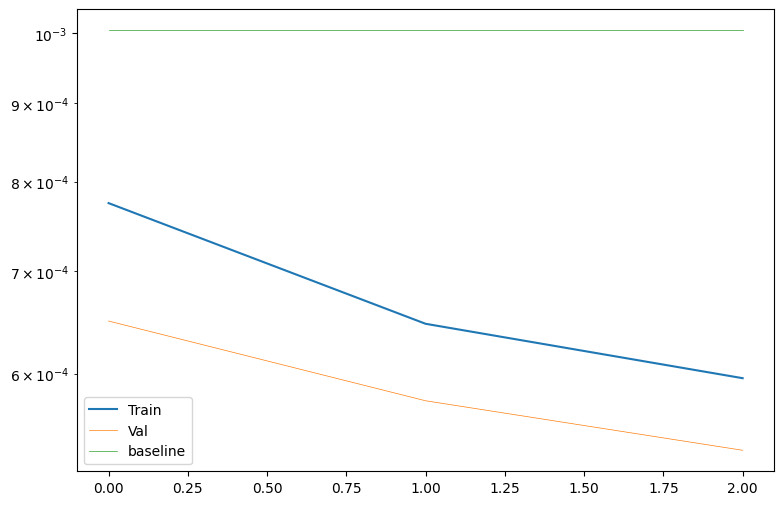

In [12]:
# Plotting shit at the end
plt.figure(figsize=(9, 6))
print(f"final val loss {losses_val[-1]} relative {losses_val_interp[-1]}")
plt.plot(np.array(losses_train), label="Train")
plt.plot(steps_val, np.array(losses_val), label="Val", linewidth=0.5)
plt.plot(steps_val, np.array(losses_val_interp), label="baseline", linewidth=0.5)
plt.yscale("log")
plt.legend()

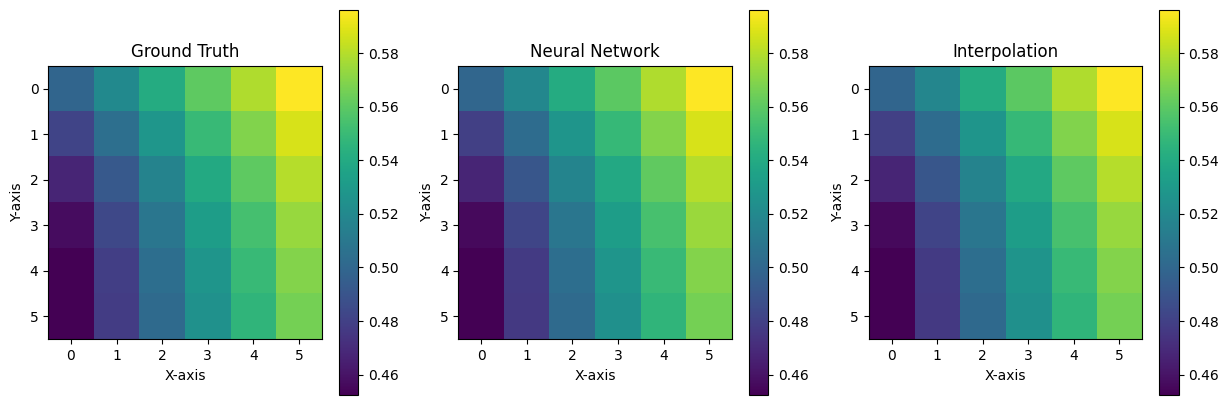

In [28]:
# Get comparison with classical methods
(y_batch,) = next(iter(test_loader))
y_batch = y_batch.to(device)
X_batch = y_batch[:, :, ::2, ::2, ::2].clone()
y_batch = y_batch[
    :, :25, diff - 1 : -diff - 1, diff - 1 : -diff - 1, diff - 1 : -diff - 1
]
# Interpolation compared to what is used typically in codes ( we interpolate between 6 values with polynomials x^i y^k z^k containing powers up to 3)
points = 6
power = 3
channels = 25
shape = X_batch.shape
interpolation = interp(
    points, power, channels, False, True, dtype=torch.double, factor=factor
)
ghosts = int(math.ceil(points / 2))


box = 0
channel = 0
slice = 0
# Note we remove some part of the grid as the interpolation needs space
max_val = torch.max(y_batch[box, channel, :, :, slice]).cpu().numpy()
min_val = torch.min(y_batch[box, channel, :, :, slice]).cpu().numpy()
net.eval()
y_pred = net(X_batch.detach())
y_interpolated = interpolation(X_batch.detach().cpu()).detach().to(torch.double)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot ground truth
axes[0].set_title("Ground Truth")
im0 = axes[0].imshow(
    y_batch[box, channel, :, :, slice].cpu().numpy(),
    vmin=min_val,
    vmax=max_val,
    cmap="viridis",
)
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")

# Plot Neural Network
axes[1].set_title("Neural Network")
im1 = axes[1].imshow(
    y_pred[box, channel, :, :, slice].detach().cpu().numpy(),
    vmin=min_val,
    vmax=max_val,
    cmap="viridis",
)
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")

# Plot Interpolation
axes[2].set_title("Interpolation")
im2 = axes[2].imshow(
    y_interpolated[box, channel, :, :, slice],
    vmin=min_val,
    vmax=max_val,
    cmap="viridis",
)
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Y-axis")

# Add colorbars
cbar0 = fig.colorbar(im0, ax=axes[0])
# cbar0.set_label('Values')
cbar1 = fig.colorbar(im1, ax=axes[1])
# cbar1.set_label('Values')
cbar2 = fig.colorbar(im2, ax=axes[2])
# cbar2.set_label('Values')

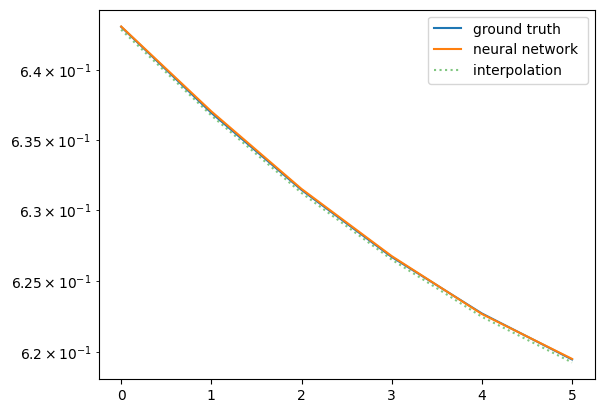

In [25]:
box = 0
channel = 0
slice = 5

net.eval()
y_pred = net(X_batch.detach())

plt.plot(
    y_batch[box, channel, :, slice, slice].detach().cpu().numpy(),
    label="ground truth",
)
plt.plot(
    y_pred[box, channel, :, slice, slice].detach().cpu().numpy(),
    label="neural network ",
)
plt.plot(
    y_interpolated[box, channel, :, slice, slice].detach().cpu().numpy(),
    label="interpolation ",
    linestyle=":",
    alpha=0.6,
)
plt.yscale("log")
plt.legend()

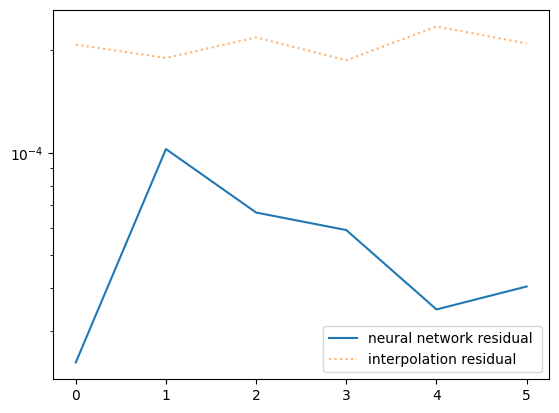

In [26]:
box = 0
channel = 0
slice = 5

net.eval()
y_pred = net(X_batch.detach())

plt.plot(
    np.abs(
        y_batch[box, channel, :, slice, slice].detach().cpu().numpy()
        - y_pred[box, channel, :, slice, slice].detach().cpu().numpy()
    ),
    label="neural network residual ",
)
plt.plot(
    np.abs(
        y_batch[box, channel, :, slice, slice].detach().cpu().numpy()
        - y_interpolated[box, channel, :, slice, slice].detach().cpu().numpy()
    ),
    label="interpolation residual",
    linestyle=":",
    alpha=0.6,
)
plt.yscale("log")
plt.legend()

In [27]:
# Calculate L2Ham performance
my_loss = Hamiltonian_loss(oneoverdx)

net.eval()
y_pred = net(X_batch.detach())

print(
    f"Reference data L2 Ham {my_loss(y_batch[:, :, :, :, :], torch.tensor([])).detach().cpu().numpy()}\n"
)
print(
    f"Neural Network L2 Ham {my_loss(y_pred[:, :, :, :, :], torch.tensor([])).detach().cpu().numpy()}\n"
)
print(
    f"Interpolation L2 Ham  {my_loss(y_interpolated, torch.tensor([])).detach().numpy()}\n"
)
print("--------------------\n")

Reference data L2 Ham 9.95904696796558e-07

Neural Network L2 Ham 0.0005349599881420729

Interpolation L2 Ham  0.0010043246094549017

--------------------



In [ ]:
# Writing out network and scaler
torch.save(net.state_dict(), file_path)

# Write out model for the C++ code to pick up
# traced_script_module = torch.jit.trace(net, X)
# traced_script_module.save("model.pt")